# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [1]:
student1 = "Davide Di Dio"
student2 = "Cyril Favre-Bulle"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(hash(student1 + student2) % 2**32)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

Using TensorFlow backend.


### Plotting

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [4]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [5]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

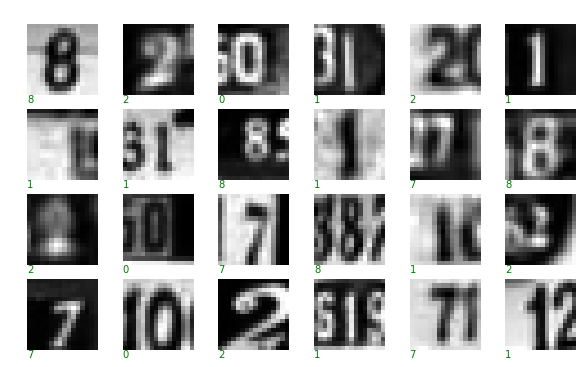

In [6]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [7]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [8]:
# shuffle training data for all the following models.
# This allow validation splitting to be uniform in the digits.
permutation = p = np.random.permutation(x_train.shape[0])
x_train = x_train[permutation]
y_train = y_train[permutation]

In [9]:
class Progress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, dictionary):
        print("epoch : %d"%(epoch), [("%s : %.4f"%(x[0], x[1])) for x in dictionary.items()], end="\r")

['20.04', '10.01']


In [10]:
model = keras.Sequential()

model.add(Dense(5, input_dim=256, activation="softmax"))
model.compile(optimizer=SGD(lr=0.01), loss="categorical_crossentropy", metrics=['accuracy'])

history = model.fit(x_train, y_train, 
                    batch_size=128, validation_split=0.2, epochs=2000, verbose=0, 
                    callbacks=[keras.callbacks.EarlyStopping("val_loss", min_delta=0, patience=50, mode="min"),
                               keras.callbacks.History(),
                               Progress()])

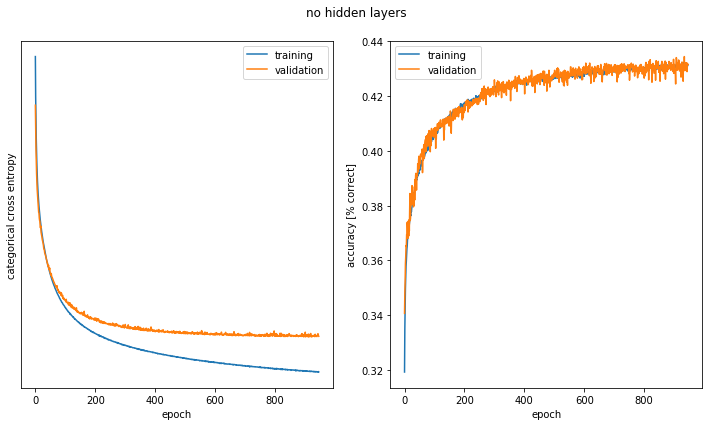

In [11]:
p = plot_history(history, "no hidden layers")

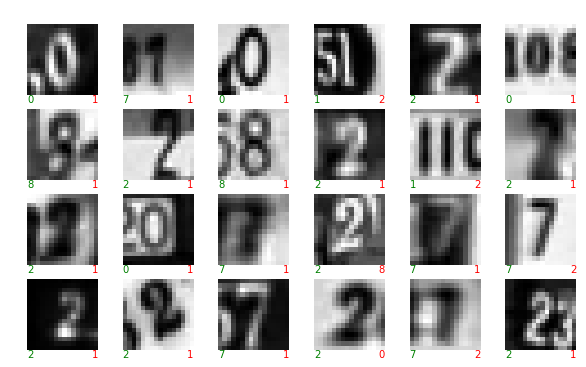

In [12]:
y_test_eval = model.predict(x_test, batch_size=128)

y_test_eval_category = y_test_eval.argmax(axis=1)
y_test_category = y_test.argmax(axis=1)

indices, = np.where(y_test_eval_category != y_test_category)

plot_some_samples(x_test, y_test, yhat=y_test_eval, select_from=indices, label_mapping = subset_of_classes);

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

In [13]:
histories = []
log_space = np.logspace(-2, 0, 10)

for learning_rate in log_space:

    model = keras.Sequential()

    model.add(Dense(64, activation="relu", input_dim=256))
    model.add(Dense(5, activation="softmax"))
    model.compile(optimizer=SGD(lr=learning_rate), loss="categorical_crossentropy", metrics=['accuracy'])

    histories.append(model.fit(x_train, y_train, 
                        batch_size=128, validation_split=0.2, epochs=50, verbose=2))

Train on 32027 samples, validate on 8007 samples
Epoch 1/50
 - 0s - loss: 1.5461 - acc: 0.3256 - val_loss: 1.5183 - val_acc: 0.3469
Epoch 2/50
 - 0s - loss: 1.5165 - acc: 0.3492 - val_loss: 1.5030 - val_acc: 0.3647
Epoch 3/50
 - 0s - loss: 1.5027 - acc: 0.3593 - val_loss: 1.4911 - val_acc: 0.3669
Epoch 4/50
 - 0s - loss: 1.4915 - acc: 0.3656 - val_loss: 1.4815 - val_acc: 0.3797
Epoch 5/50
 - 0s - loss: 1.4807 - acc: 0.3729 - val_loss: 1.4709 - val_acc: 0.3862
Epoch 6/50
 - 0s - loss: 1.4703 - acc: 0.3801 - val_loss: 1.4612 - val_acc: 0.3790
Epoch 7/50
 - 0s - loss: 1.4601 - acc: 0.3867 - val_loss: 1.4509 - val_acc: 0.3948
Epoch 8/50
 - 0s - loss: 1.4495 - acc: 0.3933 - val_loss: 1.4405 - val_acc: 0.4161
Epoch 9/50
 - 0s - loss: 1.4380 - acc: 0.4022 - val_loss: 1.4288 - val_acc: 0.4079
Epoch 10/50
 - 0s - loss: 1.4256 - acc: 0.4087 - val_loss: 1.4170 - val_acc: 0.4116
Epoch 11/50
 - 0s - loss: 1.4124 - acc: 0.4173 - val_loss: 1.4030 - val_acc: 0.4300
Epoch 12/50
 - 0s - loss: 1.3985 - a

Epoch 48/50
 - 0s - loss: 0.7413 - acc: 0.7728 - val_loss: 0.7531 - val_acc: 0.7606
Epoch 49/50
 - 0s - loss: 0.7350 - acc: 0.7748 - val_loss: 0.7450 - val_acc: 0.7656
Epoch 50/50
 - 0s - loss: 0.7288 - acc: 0.7761 - val_loss: 0.7402 - val_acc: 0.7705
Train on 32027 samples, validate on 8007 samples
Epoch 1/50
 - 0s - loss: 1.5271 - acc: 0.3372 - val_loss: 1.5021 - val_acc: 0.3552
Epoch 2/50
 - 0s - loss: 1.4936 - acc: 0.3546 - val_loss: 1.4784 - val_acc: 0.3622
Epoch 3/50
 - 0s - loss: 1.4692 - acc: 0.3700 - val_loss: 1.4537 - val_acc: 0.3850
Epoch 4/50
 - 0s - loss: 1.4398 - acc: 0.3904 - val_loss: 1.4229 - val_acc: 0.3858
Epoch 5/50
 - 0s - loss: 1.4018 - acc: 0.4187 - val_loss: 1.3832 - val_acc: 0.4613
Epoch 6/50
 - 0s - loss: 1.3575 - acc: 0.4544 - val_loss: 1.3415 - val_acc: 0.4851
Epoch 7/50
 - 0s - loss: 1.3088 - acc: 0.4879 - val_loss: 1.2873 - val_acc: 0.5011
Epoch 8/50
 - 0s - loss: 1.2590 - acc: 0.5147 - val_loss: 1.2358 - val_acc: 0.5225
Epoch 9/50
 - 0s - loss: 1.2102 - a

Epoch 45/50
 - 0s - loss: 0.5317 - acc: 0.8383 - val_loss: 0.5554 - val_acc: 0.8346
Epoch 46/50
 - 0s - loss: 0.5283 - acc: 0.8390 - val_loss: 0.5536 - val_acc: 0.8325
Epoch 47/50
 - 0s - loss: 0.5245 - acc: 0.8395 - val_loss: 0.5656 - val_acc: 0.8232
Epoch 48/50
 - 0s - loss: 0.5211 - acc: 0.8422 - val_loss: 0.5736 - val_acc: 0.8178
Epoch 49/50
 - 0s - loss: 0.5163 - acc: 0.8437 - val_loss: 0.5490 - val_acc: 0.8376
Epoch 50/50
 - 0s - loss: 0.5130 - acc: 0.8452 - val_loss: 0.5505 - val_acc: 0.8340
Train on 32027 samples, validate on 8007 samples
Epoch 1/50
 - 1s - loss: 1.5011 - acc: 0.3572 - val_loss: 1.4625 - val_acc: 0.3753
Epoch 2/50
 - 0s - loss: 1.4146 - acc: 0.4116 - val_loss: 1.3554 - val_acc: 0.4300
Epoch 3/50
 - 0s - loss: 1.2850 - acc: 0.4975 - val_loss: 1.2204 - val_acc: 0.5213
Epoch 4/50
 - 0s - loss: 1.1562 - acc: 0.5582 - val_loss: 1.1101 - val_acc: 0.5817
Epoch 5/50
 - 0s - loss: 1.0503 - acc: 0.6084 - val_loss: 1.0082 - val_acc: 0.6354
Epoch 6/50
 - 0s - loss: 0.9678 

Epoch 42/50
 - 0s - loss: 0.4162 - acc: 0.8728 - val_loss: 0.5373 - val_acc: 0.8413
Epoch 43/50
 - 0s - loss: 0.4096 - acc: 0.8743 - val_loss: 0.5070 - val_acc: 0.8446
Epoch 44/50
 - 0s - loss: 0.4035 - acc: 0.8778 - val_loss: 0.5196 - val_acc: 0.8405
Epoch 45/50
 - 0s - loss: 0.4029 - acc: 0.8753 - val_loss: 0.6290 - val_acc: 0.7917
Epoch 46/50
 - 0s - loss: 0.3996 - acc: 0.8770 - val_loss: 0.4599 - val_acc: 0.8614
Epoch 47/50
 - 0s - loss: 0.3953 - acc: 0.8795 - val_loss: 0.5886 - val_acc: 0.8174
Epoch 48/50
 - 0s - loss: 0.3918 - acc: 0.8790 - val_loss: 0.4900 - val_acc: 0.8543
Epoch 49/50
 - 0s - loss: 0.3881 - acc: 0.8810 - val_loss: 0.4821 - val_acc: 0.8531
Epoch 50/50
 - 0s - loss: 0.3863 - acc: 0.8818 - val_loss: 0.5390 - val_acc: 0.8393
Train on 32027 samples, validate on 8007 samples
Epoch 1/50
 - 1s - loss: 1.4247 - acc: 0.4015 - val_loss: 1.3560 - val_acc: 0.4263
Epoch 2/50
 - 0s - loss: 1.1485 - acc: 0.5565 - val_loss: 1.0612 - val_acc: 0.5816
Epoch 3/50
 - 0s - loss: 0.94

Epoch 39/50
 - 0s - loss: 0.3763 - acc: 0.8817 - val_loss: 0.4797 - val_acc: 0.8556
Epoch 40/50
 - 0s - loss: 0.3746 - acc: 0.8832 - val_loss: 0.4578 - val_acc: 0.8659
Epoch 41/50
 - 0s - loss: 0.3760 - acc: 0.8794 - val_loss: 0.6499 - val_acc: 0.7912
Epoch 42/50
 - 0s - loss: 0.3679 - acc: 0.8826 - val_loss: 0.4937 - val_acc: 0.8511
Epoch 43/50
 - 0s - loss: 0.3616 - acc: 0.8859 - val_loss: 0.4735 - val_acc: 0.8640
Epoch 44/50
 - 0s - loss: 0.3617 - acc: 0.8874 - val_loss: 0.5965 - val_acc: 0.8207
Epoch 45/50
 - 0s - loss: 0.3613 - acc: 0.8866 - val_loss: 0.6533 - val_acc: 0.7993
Epoch 46/50
 - 0s - loss: 0.3574 - acc: 0.8849 - val_loss: 0.5359 - val_acc: 0.8320
Epoch 47/50
 - 0s - loss: 0.3532 - acc: 0.8888 - val_loss: 0.8332 - val_acc: 0.7332
Epoch 48/50
 - 0s - loss: 0.3586 - acc: 0.8883 - val_loss: 0.6924 - val_acc: 0.8034
Epoch 49/50
 - 0s - loss: 0.3459 - acc: 0.8915 - val_loss: 0.4580 - val_acc: 0.8675
Epoch 50/50
 - 0s - loss: 0.3442 - acc: 0.8917 - val_loss: 0.4689 - val_acc:

Epoch 36/50
 - 0s - loss: 0.5017 - acc: 0.8419 - val_loss: 0.5311 - val_acc: 0.8391
Epoch 37/50
 - 0s - loss: 0.4981 - acc: 0.8446 - val_loss: 1.1340 - val_acc: 0.6640
Epoch 38/50
 - 0s - loss: 0.5012 - acc: 0.8421 - val_loss: 0.8813 - val_acc: 0.6914
Epoch 39/50
 - 0s - loss: 0.4935 - acc: 0.8429 - val_loss: 0.7186 - val_acc: 0.7766
Epoch 40/50
 - 0s - loss: 0.4906 - acc: 0.8458 - val_loss: 0.5976 - val_acc: 0.8109
Epoch 41/50
 - 0s - loss: 0.4885 - acc: 0.8443 - val_loss: 0.5511 - val_acc: 0.8365
Epoch 42/50
 - 0s - loss: 0.4870 - acc: 0.8466 - val_loss: 0.6293 - val_acc: 0.7994
Epoch 43/50
 - 0s - loss: 0.4814 - acc: 0.8478 - val_loss: 0.5392 - val_acc: 0.8363
Epoch 44/50
 - 0s - loss: 0.4759 - acc: 0.8501 - val_loss: 0.6160 - val_acc: 0.8018
Epoch 45/50
 - 0s - loss: 0.4694 - acc: 0.8529 - val_loss: 0.7639 - val_acc: 0.7792
Epoch 46/50
 - 0s - loss: 0.4714 - acc: 0.8498 - val_loss: 0.5748 - val_acc: 0.8234
Epoch 47/50
 - 0s - loss: 0.4746 - acc: 0.8503 - val_loss: 1.9759 - val_acc:

In [14]:
model = keras.Sequential()

model.add(Dense(64, activation="relu", input_dim=256))
model.add(Dense(5, activation="softmax"))
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=['accuracy'])

adam_history = model.fit(x_train, y_train, 
                         batch_size=128, validation_split=0.2, epochs=50, verbose=2)

Train on 32027 samples, validate on 8007 samples
Epoch 1/50
 - 1s - loss: 1.3999 - acc: 0.4441 - val_loss: 1.2193 - val_acc: 0.5323
Epoch 2/50
 - 0s - loss: 1.0793 - acc: 0.6055 - val_loss: 0.9650 - val_acc: 0.6599
Epoch 3/50
 - 0s - loss: 0.8942 - acc: 0.7030 - val_loss: 0.8412 - val_acc: 0.7252
Epoch 4/50
 - 0s - loss: 0.7964 - acc: 0.7469 - val_loss: 0.7702 - val_acc: 0.7605
Epoch 5/50
 - 0s - loss: 0.7358 - acc: 0.7711 - val_loss: 0.7193 - val_acc: 0.7813
Epoch 6/50
 - 0s - loss: 0.6947 - acc: 0.7852 - val_loss: 0.6958 - val_acc: 0.7761
Epoch 7/50
 - 0s - loss: 0.6596 - acc: 0.7977 - val_loss: 0.6572 - val_acc: 0.7972
Epoch 8/50
 - 0s - loss: 0.6317 - acc: 0.8046 - val_loss: 0.6354 - val_acc: 0.8074
Epoch 9/50
 - 0s - loss: 0.6091 - acc: 0.8133 - val_loss: 0.6160 - val_acc: 0.8053
Epoch 10/50
 - 0s - loss: 0.5899 - acc: 0.8182 - val_loss: 0.5945 - val_acc: 0.8154
Epoch 11/50
 - 0s - loss: 0.5736 - acc: 0.8230 - val_loss: 0.5916 - val_acc: 0.8134
Epoch 12/50
 - 0s - loss: 0.5574 - a

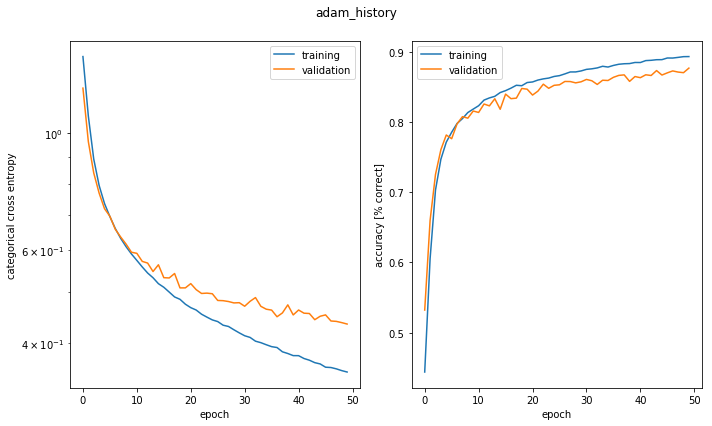

In [15]:
fig = plot_history(adam_history, "adam_history")

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) 

B) 

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

In [ ]:
model = keras.Sequential()

model.add(Dense(64, activation="relu", input_dim=256))
model.add(Dense(5, activation="softmax"))
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=['accuracy'])

adam_history = model.fit(x_train, y_train, 
                         batch_size=128, validation_split=0.2, epochs=1000, verbose=2)

In [ ]:
fig = plot_history(adam_history, "overfitting")

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: 

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

In [ ]:
x_train_reshaped = x_train.reshape((x_train.shape[0], 16, 16, 1))

In [ ]:
model = keras.Sequential()

model.add(Conv2D(64, (5, 5), activation="relu", input_shape=(16,16,1)))
model.add(Flatten())
model.add(Dense(5, activation="softmax"))
model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=['accuracy'])

adam_history = model.fit(x_train_reshaped, y_train, 
                         batch_size=128, validation_split=0.2, epochs=1000, verbose=2,
                         callbacks=[keras.callbacks.EarlyStopping("val_loss", min_delta=0, patience=20, mode="min"),
                                    keras.callbacks.History()])

In [ ]:
plot_history(adam_history, "convolution")